How to run a simple N-body code
====================

Here we will generate initial conditions for an N-body code, run a small simulation and analyse the results. This analysis is performed on a 100 star cluster in a 1 pc virial-radius King model. Stellar masses are taken randomly from a Salpeter distribution.
Stellar evolution is ignored in this simulation.

For reference you can read chapter 2 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- how to generate initial conditions (mass function, King-model)
- to initialize a gravitational N-body code
- channels and intra-code data transfer
- detecting binaries
- plotting results
- making cumulative distributions

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from amuse.units import units

We start by setting-up a simulation by specifying a stellar mass distribution

In [30]:
n_stars = 100
alpha_IMF = -2.35

from amuse.lab import new_powerlaw_mass_distribution
m_stars = new_powerlaw_mass_distribution(n_stars, 0.1|units.MSun, 
                                        100|units.MSun, alpha_IMF)

Now check to see if this indeed gives one the expected mass function by plotting the cumulative distribution against a theoretical distribution.

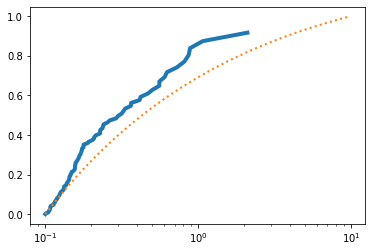

In [31]:
def plot_cdf(m, alpha_IMF=-2.35):
    m = sorted(m.value_in(units.MSun))
    fm = numpy.array([0])
    for mi in m:
        fm = numpy.append(fm, fm[-1] + mi)
    fm /= max(fm)
    from amuse.plot import plot
    pyplot.plot(m, fm[:len(m)], lw=4, ls="-")
    x = 10**numpy.arange(-1.0, 1.0, 1./len(m))    
    y = x**(alpha_IMF+2)   
    fy = numpy.array([0])     
    for yi in y:
        fy = numpy.append(fy, fy[-1] + yi)    
    fy /= max(fy)
    pyplot.plot(x, fy[:len(x)], lw=2, ls=":")
    pyplot.semilogx()
    pyplot.show()
plot_cdf(m_stars)

### Question:
Can you explain why the dotted curve does not overplot with the solid curve?

Now we can initialize the cluster size and declare the converter.

### Converter
N-body codes operate using special dimensionless N-body units (where the gravitational constant is set to unity). In order to make the code understand SI units, we must pass it a unit converter. This contains two quantities in the relevant unit system, from which AMUSE derives the proper unit conversion. Best practice is to keep those quantities on the order of the system's scale (e.g. the total mass and the radius of the outermost planet in a planetary system) to ensure numerical stability.

Also see the notebook tutorial '03-generic_units.ipynb' on the importance of converters in AMUSE. 

In [32]:
r_cluster = 1.0 | units.parsec
from amuse.units import nbody_system
converter=nbody_system.nbody_to_si(m_stars.sum(),r_cluster)
from amuse.ic.kingmodel import new_king_model
W0 = 3.0
bodies=new_king_model(n_stars, W0, convert_nbody=converter)
bodies.scale_to_standard(converter)

Check the result by plotting the X-Y positions of the bodies.

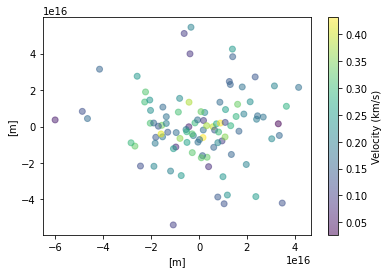

In [33]:
from amuse.plot import scatter
def plot_snapshot(bodies):
    v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
    scatter(bodies.x, bodies.y, c=v.value_in(units.kms), alpha=0.5)
    pyplot.colorbar(label = 'Velocity (km/s)')
    pyplot.show()
    
plot_snapshot(bodies)

cluster at Time= 0.0 Myr Mass= 29.2810385698 MSun Rvir= 1.0 parsec
cluster at Time= 10.0 Myr Mass= 29.2810385698 MSun Rvir= 1.00655565575 parsec
cluster at Time= 20.0 Myr Mass= 29.2810385698 MSun Rvir= 0.945354747284 parsec
cluster at Time= 30.0 Myr Mass= 29.2810385698 MSun Rvir= 1.02190867344 parsec
cluster at Time= 40.0 Myr Mass= 29.2810385698 MSun Rvir= 0.990890820172 parsec
cluster at Time= 50.0 Myr Mass= 29.2810385698 MSun Rvir= 0.953573075255 parsec
cluster at Time= 60.0 Myr Mass= 29.2810385698 MSun Rvir= 1.00234744356 parsec
cluster at Time= 70.0 Myr Mass= 29.2810385698 MSun Rvir= 0.955963592137 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
======

Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 1827640232519927055    1.016e+01    5.824e+29   -3.579e+05    0.000e+00    1.061e+10    2.302e+01    4.230e+01    1.828e+02    2.927e+15    1.825e+15    9.114e+15
 5564576255691275784    1.016e+01    5.824e+29   -3.575e+05    0.000e+00    1.061e+10   -6.190e+00    3.349e+01   -3.512e+02    3.102e+15    1.873e+15    9.179e+15
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  =====

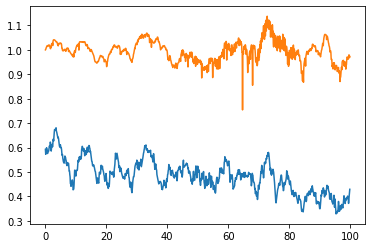

In [12]:
from amuse.community.ph4.interface import ph4
from amuse.ext.LagrangianRadii import LagrangianRadii

gravity = ph4(converter)
gravity.particles.add_particles(bodies)
# A channel is a 'permanent' connection to a code's particle
# set. Multiple calls to a code's particle set need to set up
# a new connection every time; with a channel, we can copy
# information back without opening a new connection.
# This does not automatically update bodies! See below
channel = gravity.particles.new_channel_to(bodies)


times = numpy.arange(0, 100, 0.1) | units.Myr
RL25 = [] | units.parsec
Rvir = [] | units.parsec
for time in times:
    gravity.evolve_model(time)
    channel.copy() # Copy from gravity.particles to bodies
    Rvir.append(bodies.virial_radius())
    L = LagrangianRadii(bodies)
    RL25.append(LagrangianRadii(bodies)[5])

    if not time.value_in(units.Myr)%10.0:
        print("cluster at Time=", time.in_(units.Myr), 
              "Mass=", bodies.mass.sum().in_(units.MSun),
              "Rvir=", Rvir[-1].in_(units.parsec))
    b = bodies.get_binaries()
    if(len(b)>0):
        print("Number of binaries found:", len(b))
        print("first binary:", b[0])

pyplot.plot(times.value_in(units.Myr), RL25.value_in(units.parsec))
pyplot.plot(times.value_in(units.Myr), Rvir.value_in(units.parsec))
pyplot.show()

You have now calculated the dynamical evolution of a small cluster of stars including a realistic mass function.

Assignments and questions:
---------------

### Question 1:
Why do we have to *scale_to_standard()* after assigning the masses and positions to all the particles?

### Question 2:
Run the notebook and describe the evolution of the virial radius.

### Assignment 2:
There is a check for binary detection in the script.
If no binary formed in your run, that is okay.

Run the script again until a binary forms.

### Question 3:
One of the parameters in the binary is the *hardness*.
What is the hardness of the binary from your last run, and explain what is meant with this parameter.

### Assignment 3:
Rewrite the script in such a way that the event loop over time continues indefinitely, but that the code stops as soon as the first binary is detected.

Run the script several times until you have enough first binaries formed to make a histogram of the first-binary formation time-scale.

Now, make a small change to your initial conditions.
A variation could include the dimensionless depth of the potential of the initial King model, the slope of the initial-mass function, its lower limit, or the number of stars in the simulation).

Now redo the calculation in which you generate a histogram of moments of first-binary formation.

Make one figure with both distributions: the original distribution for first-binary formation time and the second series of runs (with the altered initial conditions.
Present both distributions as histograms and as cumulative distributions. 

### Question 4:
Can you understand the difference in first-binary formation-time based on the changes you introduced in the initial conditions?

Did you perform enough runs to make a statistically significant statement about the time of first-binary formation?

### Assignment 4:
Make a cumulative distribution of the masses of the two stars for each first binary and compare it to the initial mass-function.

### Question 5:
Can you understand the difference between the typical masses of the binaries that formed first and the initial mass-function?

#### Question 1
We have to scale the Nbody system to standard units in order to ensure that its time scale is proportional to the Nbody cluster's dynamical timescale. If we wouldn't use this function, the time of the cluster would be scaled to N-body units rather than true physical units (ex. the dynamical timescale)

#### Question 2
There is a lot of noise in the evolution of the viral radius, however overall a decreasing trend with time in the value of $R_v$ can be discerned. This suggest that the cluster experiences a gravitational/core collapse (unsure if this a correct interpretation)

#### Question 3

One of the parameters in the binary is the hardness. What is the hardness of the binary from your last run, and explain what is meant with this parameter.

In [17]:
gravity = ph4(converter)
gravity.particles.add_particles(bodies)
channel = gravity.particles.new_channel_to(bodies)


times = numpy.arange(0, 100, 0.1) | units.Myr
RL25 = [] | units.parsec
Rvir = [] | units.parsec
for time in times:
    gravity.evolve_model(time)
    channel.copy() # Copy from gravity.particles to bodies
    Rvir.append(bodies.virial_radius())
    L = LagrangianRadii(bodies)
    RL25.append(LagrangianRadii(bodies)[5])

    if not time.value_in(units.Myr)%10.0:
        print("cluster at Time=", time.in_(units.Myr), 
              "Mass=", bodies.mass.sum().in_(units.MSun),
              "Rvir=", Rvir[-1].in_(units.parsec))
    b = bodies.get_binaries()
    if(len(b)>0):
        print("Number of binaries found:", len(b))
        print("first binary:", b[0])
        break


cluster at Time= 0.0 Myr Mass= 29.2810385698 MSun Rvir= 1.08492519578 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
  734232603182445403    1.018e+01    5.824e+29   -4.035e+05    0.000e+00    5.306e+09    2.911e+02   -4.146e+01    2.667e+01    4.018e+15   -6.389e+15    2.668e+15
 4800487517435927668    1.018e+01    5.824e+29   -4.000e+05    0.000e+00    5.306e+09    8.734e+01   -4.779e+01    8.042e+01    4.273e+15   -6.430e+15    2.602e+15
====================  ===========  ===========  ======

In [29]:
print('Hardness of the binary is:', b[0].hardness)

Hardness of the binary is: [ 10.17566324  10.17566324]


The hardness parameter is a measure of the binary system stability during encounters with other stars or binary system. In a soft binary system, the binaries are on average destroyed through binary–single encounters. In a hard binary system, the binaries become harder and harder through a series of binary–single encounters, and then heat the core of the cluster.

#### Assignment 3

In [96]:
t2 = np.zeros(40) | units.Myr

In [102]:
for i in range(40):

    n_stars = 200
    alpha_IMF = -2.30
    m_stars = new_powerlaw_mass_distribution(n_stars, 0.5|units.MSun, 
                                            200|units.MSun, alpha_IMF)


    r_cluster = 1.0 | units.parsec
    converter=nbody_system.nbody_to_si(m_stars.sum(),r_cluster)
    W0 = 2.0
    bodies=new_king_model(n_stars, W0, convert_nbody=converter)
    bodies.scale_to_standard(converter)



    gravity = ph4(converter)
    gravity.particles.add_particles(bodies)
    channel = gravity.particles.new_channel_to(bodies)


    times = numpy.arange(0, 300, 0.1) | units.Myr
    RL25 = [] | units.parsec
    Rvir = [] | units.parsec
    for time in times:
        gravity.evolve_model(time)
        channel.copy() # Copy from gravity.particles to bodies
        Rvir.append(bodies.virial_radius())
        L = LagrangianRadii(bodies)
        RL25.append(LagrangianRadii(bodies)[5])

        if not time.value_in(units.Myr)%10.0:
            print("cluster at Time=", time.in_(units.Myr), 
                  "Mass=", bodies.mass.sum().in_(units.MSun),
                  "Rvir=", Rvir[-1].in_(units.parsec))
        b = bodies.get_binaries()
        if(len(b)>0):
            print("Number of binaries found:", len(b))
            print("first binary:", b[0])
            break
    t2[i] = time


cluster at Time= 0.0 Myr Mass= 322.156624132 MSun Rvir= 1.0 parsec
cluster at Time= 10.0 Myr Mass= 322.156624132 MSun Rvir= 0.995324649634 parsec
cluster at Time= 20.0 Myr Mass= 322.156624132 MSun Rvir= 0.992278608957 parsec
cluster at Time= 30.0 Myr Mass= 322.156624132 MSun Rvir= 1.03911122112 parsec
cluster at Time= 40.0 Myr Mass= 322.156624132 MSun Rvir= 0.959848622328 parsec
cluster at Time= 50.0 Myr Mass= 322.156624132 MSun Rvir= 1.01801287413 parsec
cluster at Time= 60.0 Myr Mass= 322.156624132 MSun Rvir= 0.943467758708 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ==========

cluster at Time= 40.0 Myr Mass= 281.378211794 MSun Rvir= 1.01973509705 parsec
cluster at Time= 50.0 Myr Mass= 281.378211794 MSun Rvir= 0.940231965664 parsec
cluster at Time= 60.0 Myr Mass= 281.378211794 MSun Rvir= 1.01921173916 parsec
cluster at Time= 70.0 Myr Mass= 281.378211794 MSun Rvir= 0.97218076716 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
15837659820393244291    2.793e+01    2.798e+30   -1.187e+07    0.000e+00    2.140e+08   -3.780e+02    2.175e+02   -2.217e+03   -5.404e+15    9.687

cluster at Time= 60.0 Myr Mass= 394.011810304 MSun Rvir= 1.0043260757 parsec
cluster at Time= 70.0 Myr Mass= 394.011810304 MSun Rvir= 0.980455916901 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 7222034048322511298    1.038e+01    3.918e+30   -9.541e+06    0.000e+00    1.447e+09    6.140e+02   -1.707e+03    1.125e+03    8.551e+15    5.162e+15   -4.462e+15
 6648801223634985126    1.038e+01    3.918e+30   -9.504e+06    0.000e+00    1.447e+09   -1.110e+02    2.895e+02   -1.037e+03    8.608e+15  

cluster at Time= 10.0 Myr Mass= 380.441843045 MSun Rvir= 0.988251956505 parsec
cluster at Time= 20.0 Myr Mass= 380.441843045 MSun Rvir= 1.03383802683 parsec
cluster at Time= 30.0 Myr Mass= 380.441843045 MSun Rvir= 0.930979825981 parsec
cluster at Time= 40.0 Myr Mass= 380.441843045 MSun Rvir= 1.02665569911 parsec
cluster at Time= 50.0 Myr Mass= 380.441843045 MSun Rvir= 1.0167568137 parsec
cluster at Time= 60.0 Myr Mass= 380.441843045 MSun Rvir= 1.02847729125 parsec
cluster at Time= 70.0 Myr Mass= 380.441843045 MSun Rvir= 1.05855819492 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ==

cluster at Time= 50.0 Myr Mass= 461.932640134 MSun Rvir= 1.04881385199 parsec
cluster at Time= 60.0 Myr Mass= 461.932640134 MSun Rvir= 0.937894124824 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 4784330112079139980    1.232e+01    4.594e+30   -1.255e+07    0.000e+00    3.340e+08   -2.365e+03   -1.385e+01    3.075e+02    8.062e+14    9.911e+15    5.923e+14
 3637603556743628077    1.232e+01    4.594e+30   -1.255e+07    0.000e+00    3.340e+08    2.211e+03    7.118e+02    9.185e+02    8.369e+14 

Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
13936267434080134566    1.085e+01    3.073e+30   -5.047e+06    0.000e+00    1.634e+09    1.101e+02    9.221e+02   -9.407e+02   -5.182e+14   -7.290e+14   -3.683e+15
 4803237866317443608    1.085e+01    3.073e+30   -5.044e+06    0.000e+00    1.634e+09    7.262e+02   -1.798e+02   -8.299e+02   -4.416e+14   -7.549e+14   -3.707e+15
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  =====

cluster at Time= 0.0 Myr Mass= 391.062824457 MSun Rvir= 1.0 parsec
cluster at Time= 10.0 Myr Mass= 391.062824457 MSun Rvir= 1.02618333934 parsec
cluster at Time= 20.0 Myr Mass= 391.062824457 MSun Rvir= 1.00617688333 parsec
cluster at Time= 30.0 Myr Mass= 391.062824457 MSun Rvir= 1.04245167893 parsec
cluster at Time= 40.0 Myr Mass= 391.062824457 MSun Rvir= 1.05779501358 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 1691076369524197975    1.356e+01    3.889e+30   -1.098e+07    0.000e+00    3.63

cluster at Time= 20.0 Myr Mass= 291.298518821 MSun Rvir= 1.0066733555 parsec
cluster at Time= 30.0 Myr Mass= 291.298518821 MSun Rvir= 0.982466020624 parsec
cluster at Time= 40.0 Myr Mass= 291.298518821 MSun Rvir= 1.00363416694 parsec
cluster at Time= 50.0 Myr Mass= 291.298518821 MSun Rvir= 1.01752281878 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 8010521262157224874    1.193e+01    2.897e+30   -5.693e+06    0.000e+00    1.682e+09    8.765e+02   -1.032e+03    7.612e+02    5.104e+15   -1.331e

In [98]:
t

quantity<[134.5, 103.0, 161.1, 153.8, 109.6, 142.7, 133.4, 70.5, 87.9, 56.8, 138.2, 98.8, 144.6, 190.9, 150.6, 238.1, 74.8, 179.4, 69.5, 160.7, 169.3, 133.4, 98.5, 85.3, 186.5, 88.4, 107.7, 151.3, 41.6, 161.2, 86.4, 139.7, 116.6, 145.0, 92.7, 117.0, 97.5, 154.0, 106.2, 65.2] Myr>

((array([ 2.,  4.,  8.,  6.,  5.,  7.,  4.,  3.,  0.,  1.]),
  array([  41.6 ,   61.25,   80.9 ,  100.55,  120.2 ,  139.85,  159.5 ,
          179.15,  198.8 ,  218.45,  238.1 ]),
  <BarContainer object of 10 artists>),
 (array([ 1.,  3.,  2.,  9.,  6.,  7.,  4.,  3.,  2.,  3.]),
  array([  29.4 ,   37.43,   45.46,   53.49,   61.52,   69.55,   77.58,
           85.61,   93.64,  101.67,  109.7 ]),
  <BarContainer object of 10 artists>))

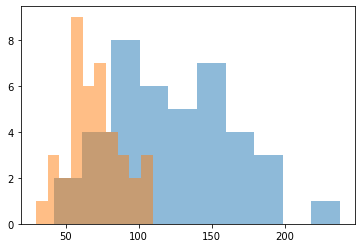

In [137]:
from amuse.plot import hist
hist(t, alpha = 0.5), hist(t2, alpha = 0.5)

#### Question 4
In the second run we have a cluster with a higher number of bodies which are allowed to have a larger mass compared to the first run. As a result core collapse is enhanced which leads to an acceleration in the formation of binaries as can be recognized on the histograms.